In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Convolutional Neural Network 구현
- MNIST 손글씨 data를 이용하여 CNN을 학습하고 MLP와 결과와 비교.

# 새 섹션

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import matplotlib.pyplot as plt
# 학습결과 그래프 함수
# loss 그래프
def plot_loss(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [2]:
# accuracy 그래프
def plot_accuracy(history):
#     plt.figure(figsize=(10,7))
    plt.plot(history.history['accuracy'], label='Train accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

# MNIST CNN 적용

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np


In [4]:
#random seed값 설정
np.random.seed(0)
tf.random.set_seed(0)

### data loading

In [5]:
(train_image, train_label), (test_image, test_label) = keras.datasets.mnist.load_data()
train_image.shape, test_image.shape



((60000, 28, 28), (10000, 28, 28))

In [6]:
LEARNING_RATE = 0.001
N_EPOCHS = 20
N_BATCHS = 100

N_TRAIN = train_image.shape[0]
N_TEST = test_image.shape[0]

### 전처리, Dataset 생성
 - X : 0 ~ 1 scaling
 - y : onehot encoding

In [8]:
X_train_tmp = (train_image / 255.0).astype(np.float32)
X_test_tmp = (test_image / 255.0).astype(np.float32)

y_train = keras.utils.to_categorical(train_label)
y_test = keras.utils.to_categorical(test_label)


#channel 축을 추가
X_train  = X_train_tmp[..., np.newaxis]
X_test = X_test_tmp[..., np.newaxis]


In [ ]:
# Dataset 생성
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(N_TRAIN).batch(N_BATCHS, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(N_BATCHS)

### Model(Network) 정의
 - Feature Extraction : Convolution layer
  - block : Convoution + MaxPooling Layer
  - size(height, width)는 줄이고 channel은 늘리는 방향으로 layer들을 쌓는다
  - convolution
    - size : 3 X 3
    - strides : 1
  - maxpooling
    - size : 2 X 2
    - strides : 2
 - 분류기
  - Dense layer를 사용
  - Flatten을 먼저 해야 한다(conv의 output-feature map : 3차원 배열)

In [ ]:
def create_mnist_model():
  model = keras.Sequential()
  #input layer - Convolution Layer의 input shape는 3차원으로 저장(heigt, width, channl), gray scale도 3차원으로 저장)
  model.add(layers.InputLayer((28, 28, 1))) #gray scale은 channel을 1로 지정

  #convolution block
  #convolution layer : Conv2D()
  model.add(layers.Conv2D(filters=32, #Filter(Kernal의 개수)
                          kernel_size = (3,3), #Filter shape(height, width) - height와 width가 같은 경우 하나만 써줘도 무방하다
                          padding='same',  #padding 방식 : 'same', 'valid'
                          strides = (1,1), #이동 간격, (상하, 좌우) : 좌우/상하가 같은 경우 동일하면 하나만 써줌(디폴트값이 (1,1))
                          activation='relu' #활성 함수
                          ))
  
  # max pooling layer : MaxPool2D() - feature map의 size를 줄여주는 역할
  model.add(layers.MaxPool2D(pool_size=(2,2), #size (height, width) - height와 width가 같은 경우 하나만 써줘도 된다(디폴트값은 (2,2))
                             strides=(2,2), #이동간격(상하, 좌우) - 동일한 경우 하나만 써도 된다(디폴트값은 pool_size와 같다) 
                             padding='same', # same, valid - same : 전체 input을 모두 사용 / valid : 마지막에 남는 영역은 버린다
                             ))
  
  model.add(layers.Conv2D(filters=64,   #filter의 개수는 늘린다 == channel의 size는 늘린다 
                          kernel_size=3,  #(3,3) 
                          padding='same',  #padding의 디폴트는 valid이므로 지정해주어야 함
                          activation='relu'
                          ))
  model.add(layers.MaxPool2D(padding='same')) #pool_size와 strides >> 기본값(2,2)사용
  model.add(layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
  model.add(layers.MaxPool2D(padding='same'))

  #Dense layer 추가
  #Flatten layer 추가 - 3차원 >> 1차원
  model.add(layers.Flatten())

  model.add(layers.Dense(units=256, activation='relu'))

  #출력
  model.add(layers.Dense(units=10, activation='softmax'))

  return model

In [ ]:
model = create_mnist_model()

model.compile(optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)             

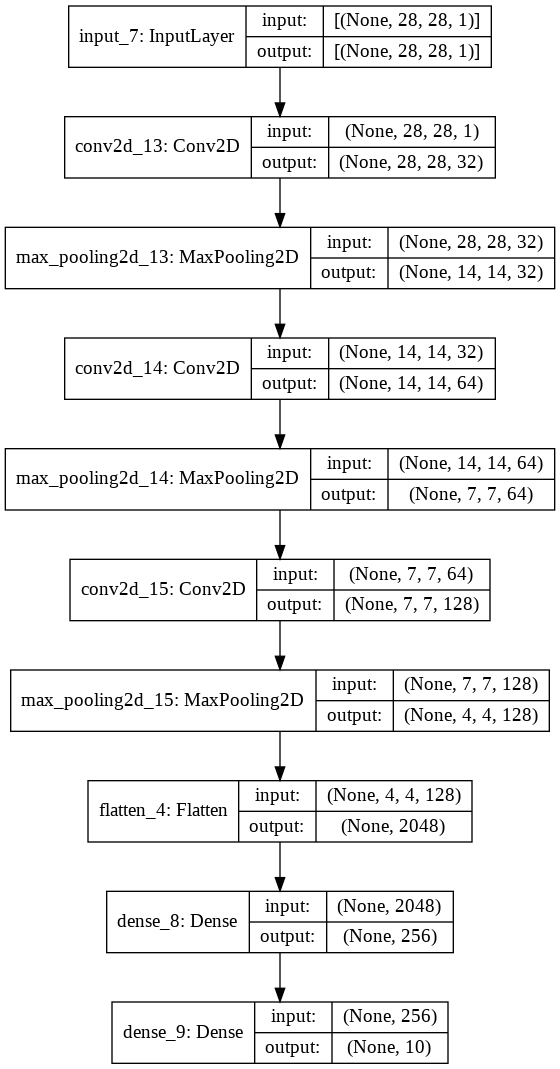

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
hist = model.fit(train_dataset, epochs=N_EPOCHS, validation_data=test_dataset)

Epoch 1/20
600/600 [==============================] - 10s 16ms/step - loss: 0.1621 - accuracy: 0.9500 - val_loss: 0.0468 - val_accuracy: 0.9847
Epoch 2/20
600/600 [==============================] - 9s 16ms/step - loss: 0.0453 - accuracy: 0.9861 - val_loss: 0.0363 - val_accuracy: 0.9886
Epoch 3/20
600/600 [==============================] - 9s 15ms/step - loss: 0.0308 - accuracy: 0.9904 - val_loss: 0.0252 - val_accuracy: 0.9911
Epoch 4/20
600/600 [==============================] - 9s 15ms/step - loss: 0.0234 - accuracy: 0.9923 - val_loss: 0.0147 - val_accuracy: 0.9950
Epoch 5/20
600/600 [==============================] - 9s 15ms/step - loss: 0.0191 - accuracy: 0.9941 - val_loss: 0.0209 - val_accuracy: 0.9933
Epoch 6/20
600/600 [==============================] - 9s 15ms/step - loss: 0.0159 - accuracy: 0.9947 - val_loss: 0.0097 - val_accuracy: 0.9969
Epoch 7/20
600/600 [==============================] - 9s 15ms/step - loss: 0.0122 - accuracy: 0.9963 - val_loss: 0.0100 - val_accuracy: 0.996

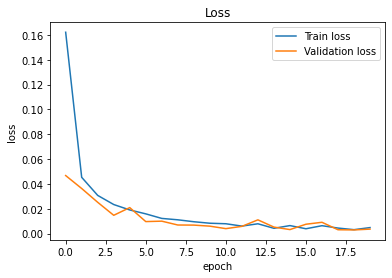

In [ ]:
plot_loss(hist)

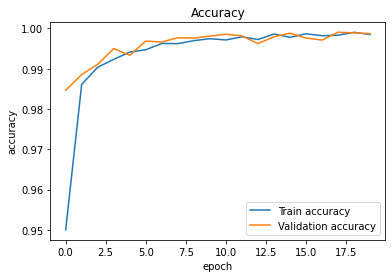

In [ ]:
plot_accuracy(hist)

In [ ]:
# 최종검증
loss, acc = model.evaluate(test_dataset)
print(loss, acc)

600/600 [==============================] - 3s 5ms/step - loss: 0.0036 - accuracy: 0.9987
0.0036157271824777126 0.9987166523933411


### prediction error가 발생한 example 확인

In [ ]:

y = np.array([1,2,3,4,5,6])
p = np.array([1,2,6,4,5,1])
r = np.where(y!=p)[0]
p[r], y[r]

(array([6, 1]), array([3, 6]))

In [ ]:
pred = model.predict(X_test)
pred.shape

(10000, 10)

In [ ]:
np.argmax(pred[0], axis=-1)

7

In [ ]:
pred[0]

array([6.6460223e-18, 4.0208906e-13, 8.6737834e-15, 2.3411991e-13,
       4.2050118e-12, 1.5939148e-17, 4.1429438e-21, 1.0000000e+00,
       7.0999096e-17, 1.9056610e-11], dtype=float32)

In [ ]:
pred_label = np.argmax(pred, axis=-1)
pred_label.shape

(10000,)

In [ ]:
pred_label[:5]

array([7, 2, 1, 0, 4])

In [ ]:
test_label.shape

(10000,)

In [ ]:
idx = np.where(test_label != pred_label)[0]
idx.shape

(81,)

In [ ]:
idx

array([   1,    2,    3, ..., 9997, 9998, 9999])

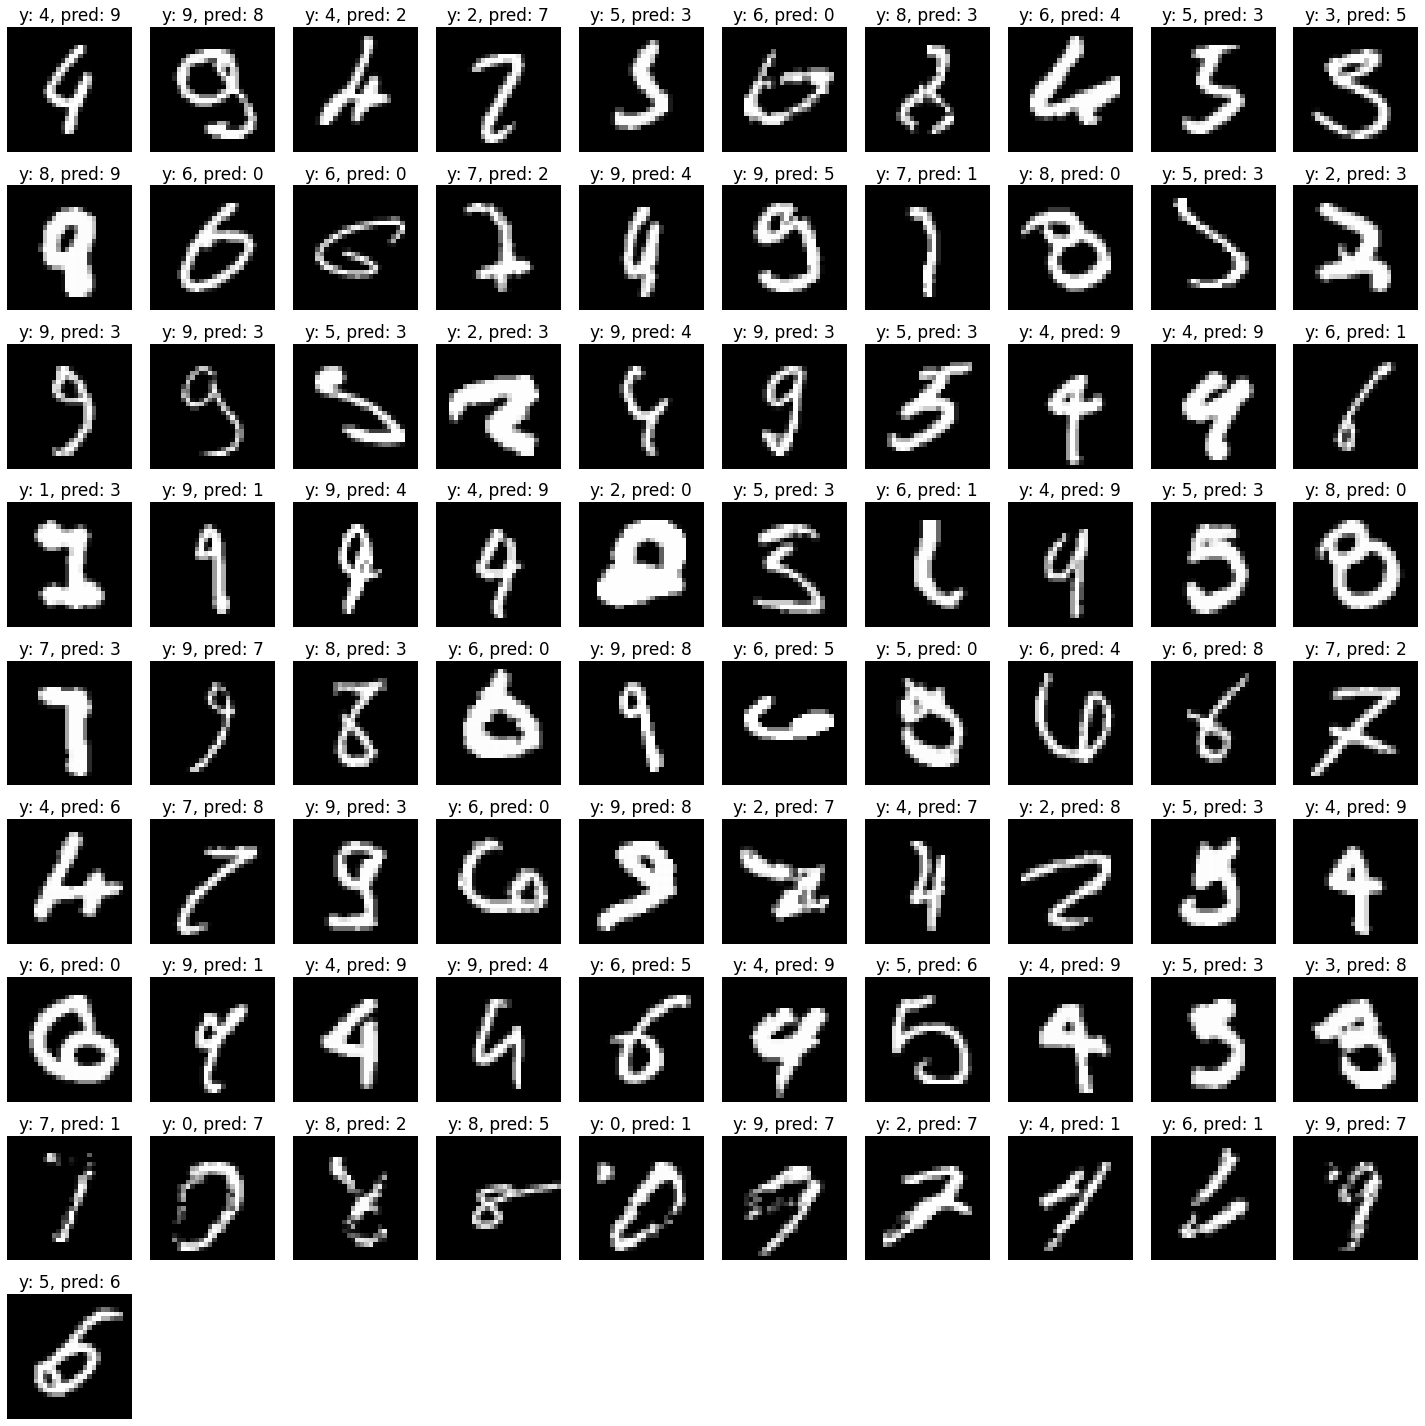

In [ ]:
# 틀린 결과 중에 10개 확인
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
for i in range(90):
    if i == 81:
        break
    error_idx = idx[i]
    
    p = pred_label[error_idx] #예측
    y = test_label[error_idx] #정답

    plt.subplot(9, 10, i+1)
    plt.imshow(test_image[error_idx], cmap='gray')
    plt.title("y: {}, pred: {}".format(y, p), fontsize=17)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 모델 저장
1. 학습이 끝난 모델의 파라미터만 저장
1. 모델 전체 저장
1. Callback 함수를 이용해 학습시 가장 좋은 지표의 모델 저장

## 텐서플로 파일 타입
- checkpoint 
    - 모델의 weight를 저장하기 위한 파일타입
- SavedModel 
    - 모델의 구조와 파라미터들을 모두 저장하는 형식

## 학습한 Weight (파라미터) 저장 및 불러오기
- 가중치를 저장하여 나중에 재학습 없이 학습된 가중치를 사용할 수 있다.
- 저장: `model.save_weights("저장경로")`
- 불러오기: `model.load_weights('불러올경로')`
- 저장형식
    - Tensorflow Checkpoint (기본방식)
    - HDF5
        - `save_weights(.., save_format='h5')`

In [ ]:
import os 

base_dir = '/content/drive/MyDrive/deeplearning_src'
mnist_weight_dir = os.path.join(base_dir, 'mnist_weight') #가중치를 저장할 경로 변수(디렉토리)

print(mnist_weight_dir)

#directory생성
if not os.path.isdir(mnist_weight_dir): #디렉토리가 있는지 여부
  os.mkdir(mnist_weight_dir) #디렉토리 생성

/content/drive/MyDrive/deeplearning_src/mnist_weight


In [ ]:
weight_file_path = os.path.join(mnist_weight_dir, 'mnist_weight.ckpt') #파일 경로
print(weight_file_path)

/content/drive/MyDrive/deeplearning_src/mnist_weight/mnist_weight.ckpt


In [ ]:
model.save_weights(weight_file_path)  #weight_file_path 경로에 학습된 파라미터(가중치)를 저장

In [ ]:
#저장된 weight르 불러오기
#모델을 생성한 뒤에 저장 weight를 덮어 씌우는 형식

new_model = create_mnist_model()
new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
new_model.evaluate(test_dataset)

600/600 [==============================] - 4s 6ms/step - loss: 2.3055 - accuracy: 0.0987


[2.3055496215820312, 0.09871666878461838]

In [ ]:
#저장된 weight를 새로운 모델에 덮어 씌우기
new_model.load_weights(weight_file_path)

In [ ]:
new_model.evaluate(test_dataset)

600/600 [==============================] - 4s 6ms/step - loss: 0.0036 - accuracy: 0.9987


[0.0036157271824777126, 0.9987166523933411]

## 전체 모델 저장하고 불러오기
- 저장: `model.save('저장할디렉토리')`
- 불러오기: `tf.keras.models.load_model('저장파일경로')`
- 저장 형식
    - Tensorflow SavedModel 형식(기본방식)
        - 모델 아키텍처 및 훈련 구성(옵티마이저, 손실 및 메트릭 포함)은 saved_model.pb 에 저장된다.
        - 파라미터는 variables/ 디렉토리에 저장된다.
        - https://www.tensorflow.org/guide/saved_model?hl=ko#the_savedmodel_format_on_disk
    - HDF5 형식
        - `save(..., save_format='h5')` 로 지정한다.
    

In [ ]:
mnist_model_dir = os.path.join(base_dir, 'mnist_model')
if not os.path.isdir(mnist_model_dir):
  os.mkdir(mnist_model_dir)

In [ ]:
model.save(mnist_model_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/deeplearning_src/mnist_model/assets


In [ ]:
#가중치는 variable 디렉토리에 저장됨

In [ ]:
new_model2 = keras.models.load_model(mnist_model_dir)

In [ ]:
new_model2.evaluate(test_dataset)

600/600 [==============================] - 4s 6ms/step - loss: 0.0036 - accuracy: 0.9987


[0.0036157271824777126, 0.9987166523933411]

## Callback을 사용한 모델 저장 및 Early Stopping
- callback은 학습하는 도중 특정 이벤트 발생시 호출되는 다양한 함수를 제공하여 자동화 처리를 지원한다. (cf: 프로그래밍의 콜백함수)
- 다양한 콜백 클래스가 제공된다.
    - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks
- `EarlyStopping`: Validation set에 대한 평가지표가  더 이상 개선되지 않을 때 학습을 자동으로 멈춤
    - `monitor`: 모니터링할 평가지표 지정. (ex: accuracy)
    - `patience`: epoch 수 지정. validation 평가 지표가 개선이 안되더라도 지정한 epoch만큼 반복한다. 지정한 epoch만큼 반복 후에도 개선이 되지 않으면 중단한다. 
- `ModelCheckpoint`: 지정한 평가지표(예:validation loss)가 가장 좋을 때 모델과 weight를 저장하여 overfitting이 발생하기 전의 model을 나중에 불러들여 사용할 수 있음
    - `save_best_only=True`: monitoring 중인 measure를 기준으로 최적의 모형의 weight만 저장 
- **callback 객체들을 리스트로 묶은 뒤 fit()의 callback 매개변수에 전달한다.**

In [ ]:
model2 = create_mnist_model()
model2.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_save_dir = os.path.join(base_dir, 'mnist_callback')

if not os.path.isdir(checkpoint_save_dir):
  os.mkdir(checkpoint_save_dir)

In [ ]:
#callback 생성
#ModelCheckpoint - 모델저장 callback
checkpoint_save_file = os.path.join(checkpoint_save_dir, 'saved_model_{epoch:04d}.ckpt') #{epoch:04d} : 몇번재 에폭
print(checkpoint_save_file)
mc_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_file,
                                              save_weights_only = True, #weight만 저장
                                              save_best_only = True, #성능 지표가 개선된 epoch의 모델을 저장(false가 디폴트 값이며 계속 저장해버림)
                                              monitor = 'val_loss',
                                              verbose = 2, #저장 로그를 남김(필수는 아님)
                                              )

/content/drive/MyDrive/deeplearning_src/mnist_callback/saved_model_{epoch:04d}.ckpt


In [ ]:
#EarlyStopping - 성능 개선이 없으면 전체 epoch을 반복하지 않고 중간에 멈춰주는 callback

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', #확인할 성능 지표
                                            patience = 5, #지정한 에폭수만큼 학습하는 동안 성능 개선이 없다면 학습을 멈춘다
                                            )

In [ ]:
#학습
hist = model2.fit(train_dataset, epochs=100, validation_data = test_dataset, callbacks=[mc_callback, es_callback]) #콜백을 여러개 붙일 수 있음

Epoch 1/100
600/600 [==============================] - 10s 17ms/step - loss: 0.0035 - accuracy: 0.9988 - val_loss: 7.7560e-04 - val_accuracy: 0.9998

Epoch 00001: val_loss improved from inf to 0.00078, saving model to /content/drive/MyDrive/deeplearning_src/mnist_callback/saved_model_0001.ckpt
Epoch 2/100
600/600 [==============================] - 10s 16ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 0.0025 - val_accuracy: 0.9993

Epoch 00002: val_loss did not improve from 0.00078
Epoch 3/100
600/600 [==============================] - 9s 16ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0010 - val_accuracy: 0.9996

Epoch 00003: val_loss did not improve from 0.00078
Epoch 4/100
600/600 [==============================] - 10s 16ms/step - loss: 0.0029 - accuracy: 0.9991 - val_loss: 0.0026 - val_accuracy: 0.9992

Epoch 00004: val_loss did not improve from 0.00078
Epoch 5/100
600/600 [==============================] - 9s 16ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0

In [ ]:
new_model3 = keras.models.load_model('/content/drive/MyDrive/deeplearning_src/mnist_callback/saved_model_0001.ckpt')

In [ ]:
new_model3.evaluate(test_dataset)

600/600 [==============================] - 4s 6ms/step - loss: 0.0399 - accuracy: 0.9879


[0.039895568042993546, 0.9879000186920166]